<a id="topD"></a>

# Downloading COS Data

# Learning Goals
### This Notebook is designed to walk the user (*you*) through: **Filtering Cosmic Origins Spectrograph (COS) TIME-TAG data using the splittag tool**
<!--    #### 1. [**Using the web browser interface**](#mastD)
   ##### - 1.1. [The Classic HST Web Search](#mastD)
   ##### - 1.2. [Searching for a Series of Observations on the Classic Web Search](#WebSearchSeriesD)
   ##### - 1.3. [The New MAST Portal](#mastportD)
   ##### - 1.4. [Searching for a Series of Observations on the New MAST Portal](#mastportSeriesD)
   #### 2. [**Using the `Python` module `Astroquery`**](#astroqueryD)
   ##### - 2.1. [Searching for a single source with Astroquery](#Astroquery1D)
   ##### - 2.2. [Narrowing Search with Observational Parameters](#NarrowSearchD)
   ##### - 2.3. [Choosing and Downloading Data Products](#dataprodsD)
   ##### - 2.4. [Using astroquery to find data on a series of sources](#Astroquery2D)
 -->


# 0. Introduction
#### The Cosmic Origins Spectrograph ([*COS*](https://www.nasa.gov/content/hubble-space-telescope-cosmic-origins-spectrograph)) is an ultraviolet spectrograph on-board the Hubble Space Telescope([*HST*](https://www.stsci.edu/hst/about)) with capabilities in the near ultraviolet (*NUV*) and far ultraviolet (*FUV*).

#### This tutorial aims to prepare you to work with the COS data of your choice by walking you through filtering `TIME-TAG` datapoints obtained by COS based on arbitrary times.

COS Data can be taken in [`TIME-TAG`](https://hst-docs.stsci.edu/cosdhb/chapter-1-cos-overview/1-1-instrument-capabilities-and-design) mode, in which each individual encounter with a photon is recorded with its own metadata such as the time of the encounter. You may wish to split a COS exposure into multiple subexposure files. For instance, a transit may occur during your exposure, and you may wish to see the difference between the source's spectrum before, during, and after the transit. This is possible with `TIME-TAG` data, and the functionality to do this is built into the [`COSTools` python module](https://github.com/spacetelescope/costools) with the tool `splittag`. 

- For an in-depth manual to working with COS data and a discussion of caveats and user tips, see the [COS Data Handbook](https://hst-docs.stsci.edu/display/COSDHB/).
- For a detailed overview of the COS instrument, see the [COS Instrument Handbook](https://hst-docs.stsci.edu/display/COSIHB/).


## We will define a few directories in which to place our data.

In [ ]:
# These will be important directories for the notebook
cwd = !pwd
cwd = cwd[0]
!mkdir ./data
data_dir = cwd + '/data/'

In [2]:
# Wide set of imports
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy as sp
import scipy.signal as signal
from astropy.io import fits
from astropy import units as u
from astroquery.mast import Observations as Obs
import glob

In [3]:
from calcos import calcos
from costools import splittag, x1dcorr

from astropy.table import Table

import natpy

The following tasks in the costools package can be run with TEAL:
         splittag                 timefilter                 x1dcorr


In [11]:
output_dir =  './output/'
plots_dir = './output/plots/'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
if not os.path.exists(plots_dir):
    os.mkdir(plots_dir)

In [12]:
pl = Obs.get_product_list(Obs.query_criteria(obs_id = 'lc1va0*'))
plf = Obs.filter_products(pl, productSubGroupDescription =  ('CORRTAG_A','CORRTAG_B'))
downloaded_corrtags = Obs.download_products(plf)['Local Path']
plf = Obs.filter_products(pl, productSubGroupDescription = ('X1D'))
downloaded_x1ds = Obs.download_products(plf)['Local Path']

INFO: Found cached file ./mastDownload/HST/lc1va0yeq/lc1va0yeq_corrtag_a.fits with expected size 5564160. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/lc1va0yjq/lc1va0yjq_corrtag_a.fits with expected size 4129920. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/lc1va0zcq/lc1va0zcq_corrtag_a.fits with expected size 14788800. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/lc1va0zgq/lc1va0zgq_corrtag_a.fits with expected size 8593920. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/lc1va0yeq/lc1va0yeq_x1d.fits with expected size 1716480. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/lc1va0yjq/lc1va0yjq_x1d.fits with expected size 1716480. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/lc1va0zcq/lc1va0zcq_x1d.fits with expected size 1716480. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/lc1va0zgq/lc1va0zgq_x1d.fits with expected size 1716480. [astroquery.query]


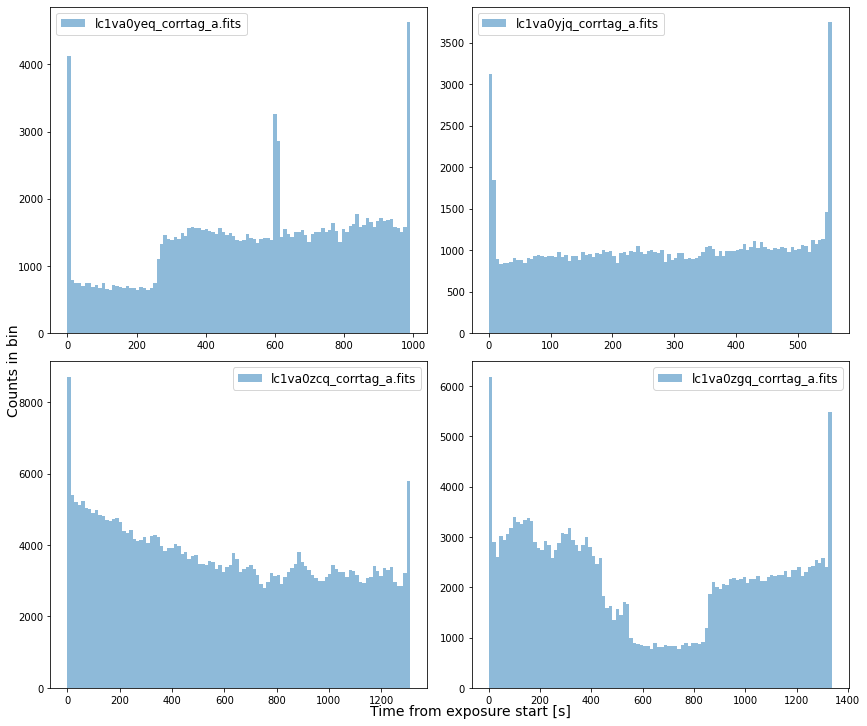

In [14]:
fig = plt.figure(figsize = (12, 10))
gs = fig.add_gridspec(nrows = 2, ncols = 2) # Using gridspec to let us control panel sizes and locations

for i, ctag in enumerate(downloaded_corrtags):
    ax = fig.add_subplot(gs[int(i/2),i%2])
    ctab = Table.read(ctag,1)
    timesc = ctab['TIME']
    a,b,c = ax.hist(timesc,bins = 100, alpha = 0.5, label = os.path.basename(ctag))
    plt.legend(fontsize = 12)
    
fig.text(x = 0.42, y = -0.0001, s = "Time from exposure start [s]", 
        fontsize = 14)
fig.text(y = 0.42, x = -0.0002, rotation = 'vertical', s = "Counts in bin", 
        fontsize = 14)
plt.tight_layout()
plt.savefig(plots_dir + 'compare_exposures.png', bbox_inches = 'tight', dpi = 200)

In [4]:
!rm -r ./output
chosen_corrtag = downloaded_corrtags[3]
natpy.fitsfile.fitsfile(chosen_corrtag).prihdr['T*']

rm: cannot remove `./output': No such file or directory


TELESCOP= 'HST'                / telescope used to acquire data                 
TARGNAME= 'IY-UMA                         ' / proposer's target name            
TAGFLASH= 'AUTO            '   / Type of flashed exposures in time-tag          
TEMPCORR= 'COMPLETE'           / correct for thermal distortion                 
TRCECORR= 'OMIT    '           / trace correction                               
TDSCORR = 'PERFORM '           / switch for time-dependent sensitivity correctio
TRACETAB= 'N/A                    ' / 1D spectral trace table                   
TWOZXTAB= 'N/A                    ' / Two-zone spectral extraction parameters   
TDSTAB  = 'lref$52m2056fl_tds.fits' / time-dependent sensitivity correction tabl
TARDESCR= 'STAR;DWARF NOVA                                                     '
TARDESC2= '                                                                    '

In [53]:
!mkdir -p ./output/reg_intervals # for intervals specified by start/stop/interval
!mkdir -p ./output/spec_intervals # for intervals specified by endpoints

splittag.splittag(infiles=chosen_corrtag, 
                  outroot='./output/reg_intervals/lc1va0zgq',
                  starttime=0., 
                  increment=260,
                  endtime=1300.)

./output/reg_intervals/lc1va0zgq_1_corrtag_a.fits written
./output/reg_intervals/lc1va0zgq_2_corrtag_a.fits written
./output/reg_intervals/lc1va0zgq_3_corrtag_a.fits written
./output/reg_intervals/lc1va0zgq_4_corrtag_a.fits written
./output/reg_intervals/lc1va0zgq_5_corrtag_a.fits written


In [54]:
splittag.splittag(infiles=chosen_corrtag, 
                  outroot='./output/spec_intervals/lc1va0zgq',
                  time_list = "0,450,850,1300")

./output/spec_intervals/lc1va0zgq_1_corrtag_a.fits written
./output/spec_intervals/lc1va0zgq_2_corrtag_a.fits written
./output/spec_intervals/lc1va0zgq_3_corrtag_a.fits written


In [55]:
reg_outlist = glob.glob('./output/reg_intervals/*fits')
spec_outlist = glob.glob('./output/spec_intervals/*fits')

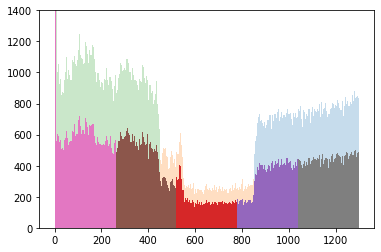

In [58]:
for rs in spec_outlist:
    ffs = Table.read(rs,1)
    timess = ffs['TIME']
    d,e,f = plt.hist(timess,100, alpha = 0.25)
    
for rf in reg_outlist:
    ffr = Table.read(rf,1)
    timesr = ffr['TIME']
    a,b,c = plt.hist(timesr,100)

plt.ylim(0,1400)
plt.show()

In [66]:
for corrtag in spec_outlist:
    print(f"Extracting file {corrtag} using CalCOS")
    calcos(corrtag, outdir = './output/calcos/', verbosity = 0)

Extracting file ./output/spec_intervals/lc1va0zgq_3_corrtag_a.fits using CalCOS
CALCOS version 3.3.10
numpy version 1.19.2
astropy version 4.0.2
Shifting to 189, 0
Shifting to 189, 0
Extraction algorithm = BOXCAR


    error estimate for y location = 7.77, FWHM = 5.28
Extracting file ./output/spec_intervals/lc1va0zgq_2_corrtag_a.fits using CalCOS
CALCOS version 3.3.10
numpy version 1.19.2
astropy version 4.0.2
Shifting to 189, 0
Shifting to 189, 0
Extraction algorithm = BOXCAR
    error estimate for y location = 16.14, FWHM = 5.72
Extracting file ./output/spec_intervals/lc1va0zgq_1_corrtag_a.fits using CalCOS
CALCOS version 3.3.10
numpy version 1.19.2
astropy version 4.0.2
Shifting to 189, 0
Shifting to 189, 0
Extraction algorithm = BOXCAR
    error estimate for y location = 5.93, FWHM = 5.45


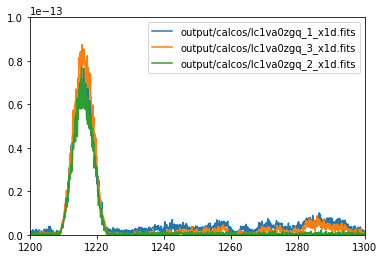

In [70]:
processed_files = glob.glob('output/calcos/*x1d.fits')
for pfile in processed_files:
    w,f = Table.read(pfile)[0]['WAVELENGTH','FLUX']
    plt.plot(w,f, label = pfile)
plt.xlim(1200,1300)    
plt.ylim(0,1E-13)
plt.legend()

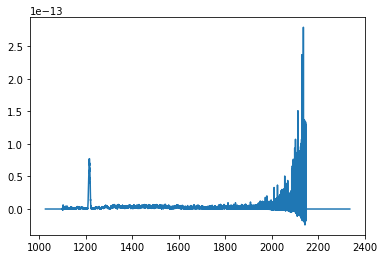

In [39]:
w,f = Table.read('./mastDownload/HST/lc1va0zgq/lc1va0zgq_x1d.fits')[0]['WAVELENGTH','FLUX']
plt.plot(w,f)

---
While not implemented within the Jupyter Notebook framework, you can also run `splittag` from a TEAL graphical user interface on a local computer (see FIG ???).

To generate the gui, open an astroconda python distribution (as described in the [Setup Notebook](), and run the following lines of python code:

```python
import costools
from stsci.tools import teal
teal.teal('splittag')
```

### Fig ???
<center><img src="./figures/TEAL_GUI.png" width ="900" title="TEAL GUI Interface"> </center>